In [22]:
import jax 
import jax.numpy as jnp
import jax.random as jr
from jax.config import config
import distrax
import pandas as pd
import numpy as np
from glob import glob 
from jax import vmap, jit 
import polars as pl 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange, tqdm
import ot
from ensembles import ProcessModel, ModelCollection

# Enable Floa64 - this is crucial for more stable matrix inversions.
config.update("jax_enable_x64", True)

key = jr.PRNGKey(123)

In [2]:
def combine_dfs(files):
    base_df = pd.DataFrame()
    base_df["time"] = pd.date_range(start="1850-01-01", periods=1980, freq="M")
    for file in files:
        df = pd.read_csv(file)
        df.drop(["Unnamed: 0"], axis=1, inplace=True)
        mn = file.split("/")[-1][:-4]  # Unique model identifier
        for col in df.columns:
            if col != "time":
                new_col_name = mn + "_" + col
                base_df[new_col_name] = df[col]
    base_df.set_index("time", inplace=True)
    return base_df


In [3]:
n_years = 145
n_years_predict = 5
n_inducing = 400
epochs = 1000
log_freq = 50

In [33]:
obs_df = pd.read_csv("data/obs/Lancs_OBS.csv", index_col="time").iloc[:, :20]
observations = ProcessModel(obs_df, model_name='Observations')
obs_df.head()

,1,10,100,101,102,103,104,105,106,107,108,109,11,110,111,112,113,114,115,116
time,,,,,,,,,,,,,,,,,,,,
1850-01-16 12:00:00,-1.928491,-1.718537,-1.854307,-1.355573,-1.363727,-2.273555,-1.969039,-1.536477,-1.434668,-1.957513,-1.439234,-1.652005,-1.814591,-2.318667,-1.864390,-2.122161,-2.075559,-1.516106,-1.577340,-1.545997
1850-02-15 00:00:00,0.629245,0.810487,0.038480,1.495604,0.914810,0.298652,0.379048,1.103577,1.025198,0.563027,1.032309,0.863302,0.599632,0.386794,0.606779,0.561789,0.416359,0.725573,0.843602,0.807448
1850-03-16 12:00:00,-0.794412,-0.933346,-1.449751,-0.666979,-0.814223,-1.189398,-1.389544,-0.862400,-0.622749,-1.044076,-0.829734,-0.691828,-1.215802,-1.241490,-1.018045,-1.211872,-1.050527,-1.034044,-0.505870,-1.024475
1850-04-16 00:00:00,-0.263984,0.284365,0.118719,0.476575,0.367194,-0.157777,-0.198578,0.188847,0.296873,-0.000331,0.411300,0.090487,0.234011,-0.246564,0.154938,0.095947,-0.097793,0.118246,0.735044,0.163690
1850-05-16 12:00:00,-0.920005,-0.304131,-0.288596,0.005852,-0.206634,-0.546038,-0.816426,-0.310775,0.087994,-0.222382,-0.354147,-0.441244,-0.029103,-0.602705,-0.397858,-0.306877,-0.436151,-0.420738,0.106846,-0.131664


In [35]:
model_files = glob('data/lancs/*csv')
model_names = [mf.split("/")[-1][:-4] for mf in model_files] 

def calc_clim(df):
    t0 = '1961-01-01'
    t1 = '1990-31-12'
    df['month'] = [int(t.split('-')[1]) for t in df.index]
    for col in df.columns[:-1]:
        clim_df = df[[col, 'month']][np.logical_and(df.index >= t0, df.index <= t1)]
        clim = clim_df.groupby(["month"]).mean()[col].values
        clim_tot = np.tile(clim, len(df) // 12)
        df[col] = df[col] - clim_tot
    df.drop(['month'], axis=1, inplace=True)
    return df

In [36]:
df = pd.read_csv(model_files[0], index_col='time').drop('Unnamed: 0', axis=1)
pm_data = ProcessModel(df,model_names[0])

In [37]:
assert all(pm_data.unstandardise_data(pm_data.standardise_data()) == df)


In [38]:
standardisers = {}

model_lls = {}
models = []

for mf, mn in zip(model_files, model_names):
    df = pd.read_csv(mf, index_col='time').drop('Unnamed: 0', axis=1)
    model_data = ProcessModel(df, mn)

    anomaly_data = ProcessModel(model_data.calculate_climatology(), mn)
    models.append(anomaly_data)

    distribution = anomaly_data.as_multivariate_gaussian

    lls = []
    log_likelihood = jit(lambda x: distribution.log_prob(x))

    for realisation in tqdm(observations):
        lls.append(log_likelihood(realisation.reshape(-1, 1)))
    model_lls[mn] = jnp.array(lls)

 95%|█████████▌| 19/20 [00:01<00:00,  9.55it/s]


In [39]:
model_set = ModelCollection(models)

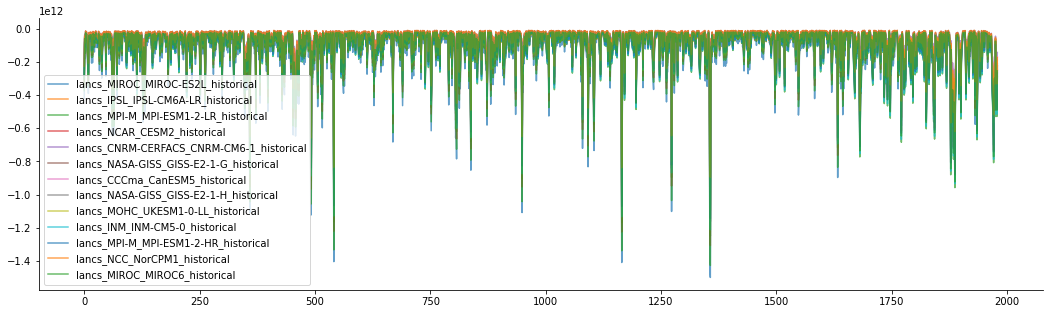

In [41]:
fig, ax = plt.subplots(figsize=(18, 5))

for model in model_lls.keys():
    lls = model_lls[model]
    ax.plot(jnp.mean(model_lls[model], axis=0), label=model, alpha=0.7)

ax.legend(loc='best')
sns.despine()
# ax.set_xlim(0, 100)

In [42]:
mean_lls = {}
for model in model_lls.keys():
    mean_ll = np.asarray(np.mean(model_lls[model], axis=0))
    mean_lls[model] = mean_ll ** 2

ll_df = pd.DataFrame.from_dict(mean_lls, orient='index').T
ll_df = ll_df.div(ll_df.sum(axis=1), axis=0)

In [46]:
ll_df.columns

Index(['lancs_MIROC_MIROC-ES2L_historical',
       'lancs_IPSL_IPSL-CM6A-LR_historical',
       'lancs_MPI-M_MPI-ESM1-2-LR_historical', 'lancs_NCAR_CESM2_historical',
       'lancs_CNRM-CERFACS_CNRM-CM6-1_historical',
       'lancs_NASA-GISS_GISS-E2-1-G_historical',
       'lancs_CCCma_CanESM5_historical',
       'lancs_NASA-GISS_GISS-E2-1-H_historical',
       'lancs_MOHC_UKESM1-0-LL_historical', 'lancs_INM_INM-CM5-0_historical',
       'lancs_MPI-M_MPI-ESM1-2-HR_historical', 'lancs_NCC_NorCPM1_historical',
       'lancs_MIROC_MIROC6_historical'],
      dtype='object')

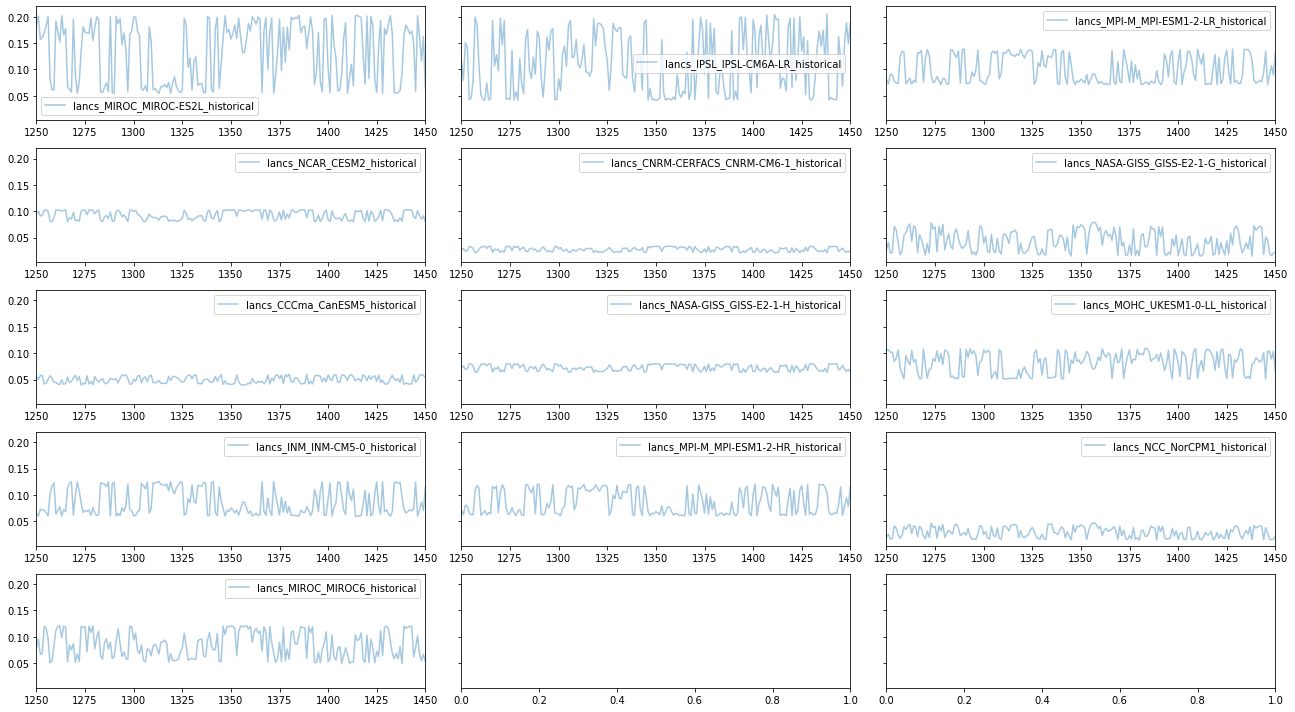

In [60]:
# fig, ax = plt.subplots(figsize=(18, 10))
# # ll_df[['lancs_MPI-M_MPI-ESM1-2-LR_historical', 'lancs_MPI-M_MPI-ESM1-2-HR_historical']].plot(ax=ax, alpha=0.6)
# ll_df.plot(ax=ax, alpha=0.4)
# # ll_df[['lancs_NASA-GISS_GISS-E2-1-G_historical']].plot(ax=ax, alpha=0.4)
# # ax.set_xlim(1650, 1750)


fig, axes = plt.subplots(figsize=(18, 10), tight_layout=True, nrows=5, ncols=3, sharey=True)

for col, ax in zip(ll_df.columns, axes.ravel()):
    df_slice = ll_df[[col]]
    df_slice.plot(ax=ax, alpha=0.4)
    ax.set_xlim(1250, 1450)


In [44]:
weights = ll_df.values[0, :]
np.testing.assert_almost_equal(np.sum(weights), 1.)

In [45]:
mean_preds = []
for mvn in mvns.values():
    samples = mvn.sample(key)

TypeError: sample() takes 1 positional argument but 2 were given

In [159]:
list(mvns.values())[0].sample(seed=key, sample_shape=(10, )).shape

(10, 1740)

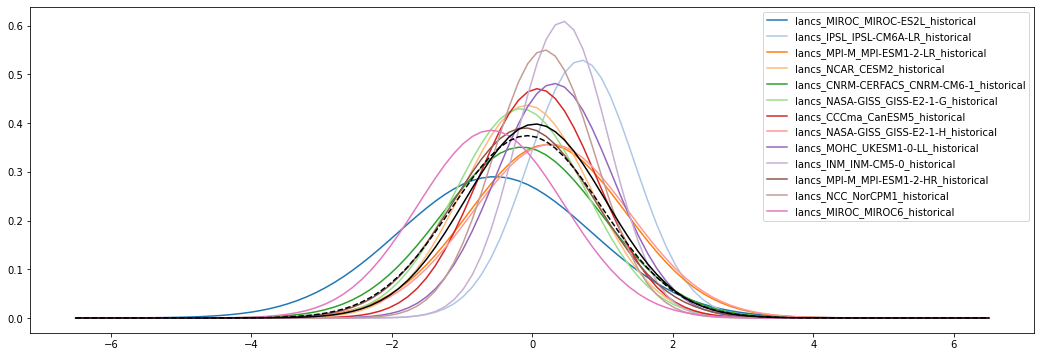

In [160]:
t = 1500
xlims = (-6.5, 6.5)
eval_x = jnp.linspace(*xlims, 100)
sns.set_palette('tab20')

fig, ax = plt.subplots(figsize=(18, 6))
for name, mvn in mvns.items():
    m = mvn.mean()[t]
    s = jnp.sqrt(mvn.variance()[t])
    ax.plot(eval_x, distrax.Normal(m, s).prob(eval_x), label=name)

ax.legend(loc='best')

ax.plot(eval_x, weighted_barycentre(t, weights), 'k--', label='Barycentre')
ax.plot(eval_x, weighted_barycentre(t, [1/13] * 13), 'k-', label='naive Barycentre')


In [161]:
weights

array([0.21561577, 0.04284722, 0.0327669 , 0.12911757, 0.01787927,
       0.06448407, 0.02268135, 0.12841225, 0.0329193 , 0.0106148 ,
       0.11748262, 0.11172398, 0.07345489])

In [143]:
def weighted_barycentre(t_idx, weights):
    pdfs = []
    for name, mvn in mvns.items():
        m = mvn.mean()[t_idx]
        s = jnp.sqrt(mvn.variance()[t_idx])
        pdfs.append(distrax.Normal(m, s).prob(eval_x))

    A = np.vstack(pdfs).T

    # loss matrix + normalization
    M = ot.utils.dist0(len(pdfs[0]))
    M /= M.max()
    weights = np.array(weights)
    # wasserstein
    reg = 1e-3
    bary_wass = ot.bregman.barycenter(A, M, reg, weights)
    return bary_wass

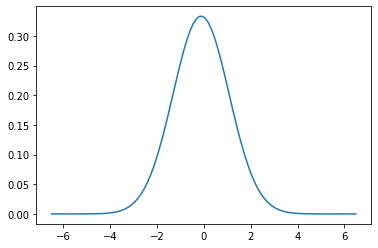

In [148]:
plt.plot(eval_x, weighted_barycentre(0, weights))